
A introduction tutorial to fMRI decoding
==========================================

by Nilearn Team

added/modified by Ralf Schmaelzle, 2020


This tutorial reproduces parts of the classic Haxby 2001 study on a face vs cat discrimination task in a mask of the ventral stream. 

In [1]:
import warnings
warnings.filterwarnings('ignore')
from nilearn import plotting
from nilearn.image import mean_img
%matplotlib inline

from nilearn import datasets

Retrieve and load the fMRI data from the  Haxby study
------------------------------------------------------

First download the data. The `nilearn.datasets.fetch_haxby` function will download the Haxby dataset if not present on the disk, in the nilearn data directory. It can take a while to download about 310 Mo of data from the Internet.

In [2]:
# By default 2nd subject will be fetched
haxby_dataset = datasets.fetch_haxby()
# 'func' is a list of filenames: one for each subject
fmri_filename = haxby_dataset.func[0]

# print basic information on the dataset
print('First subject functional nifti images (4D) are at: %s' %
      fmri_filename)  # 4D data

First subject functional nifti images (4D) are at: /Users/Ralf/nilearn_data/haxby2001/subj2/bold.nii.gz


Visualizing the fmri volume. One way to visualize a fmri volume is using `nilearn.plotting.plot_epi`.
We will visualize the previously fecthed fmri data from Haxby dataset.

Because fmri data is 4D (it consists of many 3D EPI images), we cannot plot it directly using `nilearn.plotting.plot_epi` (which accepts just 3D input). Here we are using `nilearn.image.mean_img` to 
extract a single 3D EPI image from the fmri data.


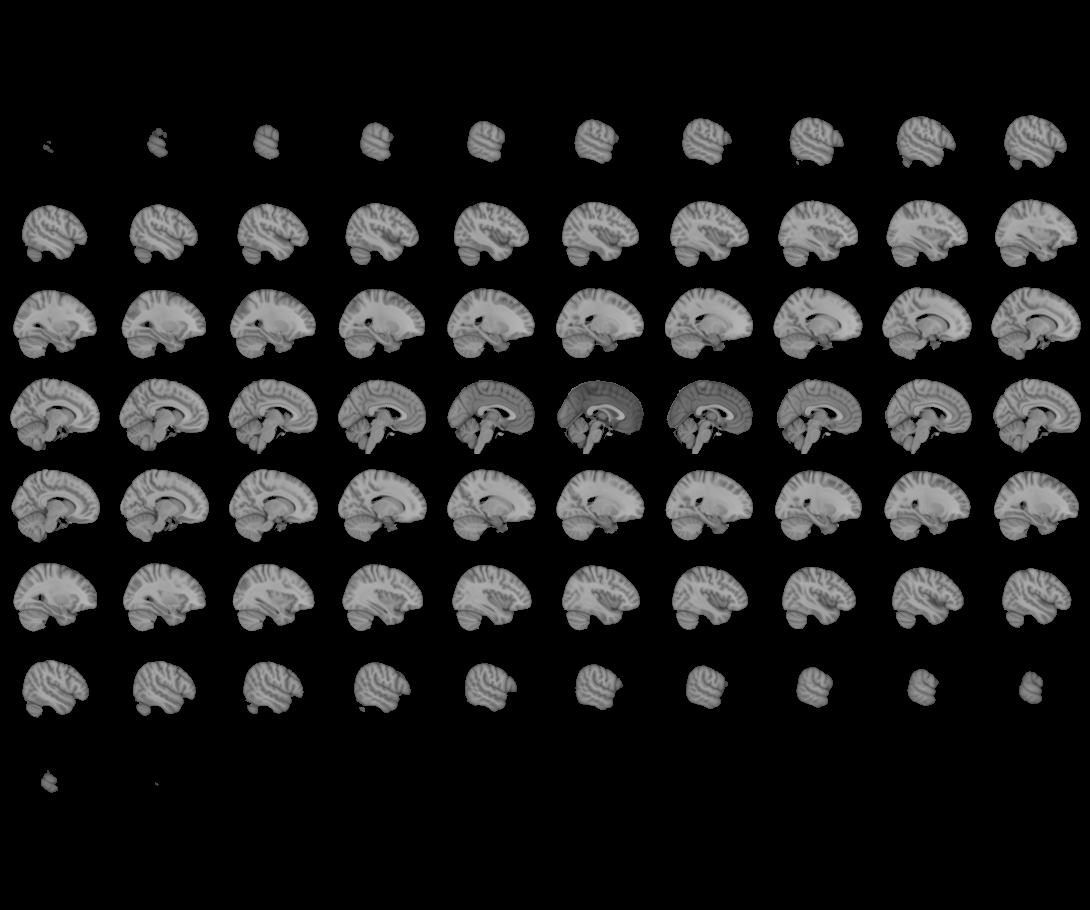
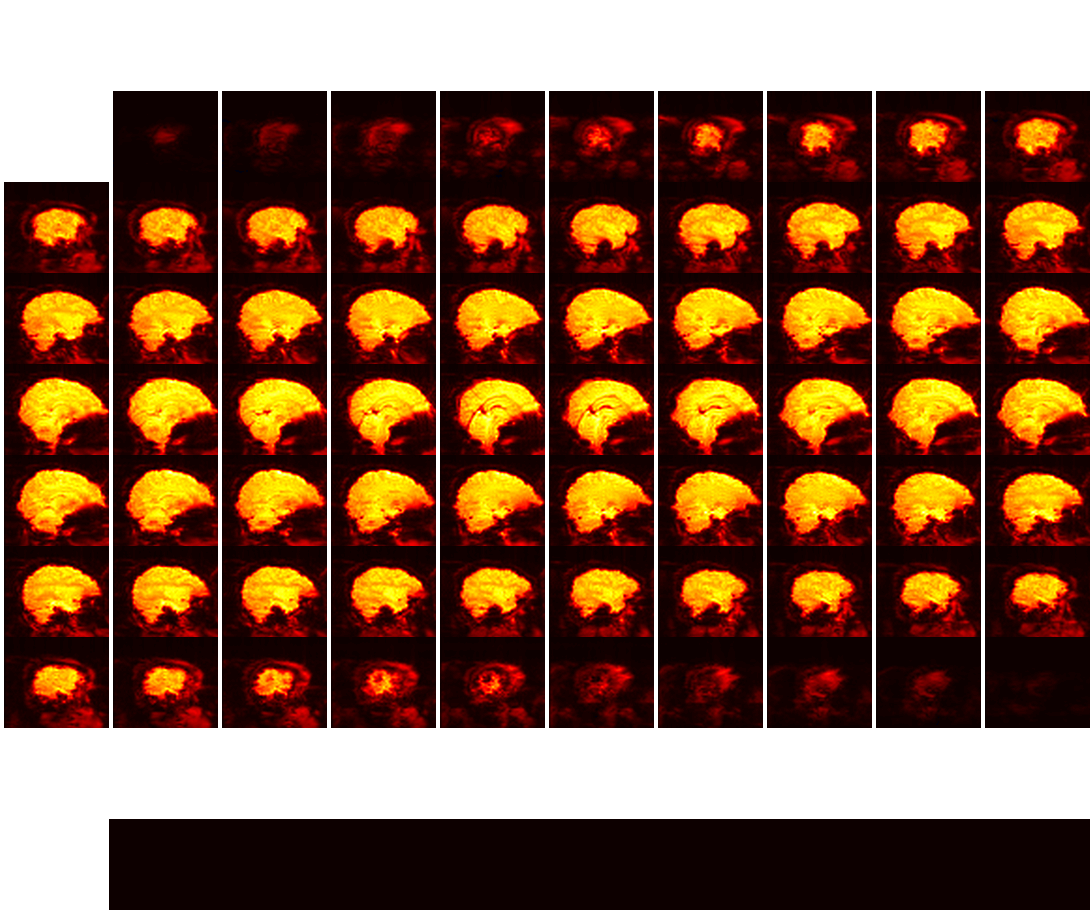

In [3]:
plotting.view_img(mean_img(fmri_filename), threshold=None)

Feature extraction: from fMRI volumes to a data matrix

These are some really lovely images, but for machine learning we need matrices to work with the actual data. That is, what we want is a matrix that contains voxeldata aligned on a row, and the cases (e.g. trials ..) as rows.

e.g. 

trial_type/label, voxel1, voxel2, volxel3 .... voxelN

face, 0.8, 0.3, 0.5,... 0.9

house, 0.7, 0.6, 0.4, ...0.6

face, 0.4, 0.6, 0.5,... 0.7

face, 0.8, 0.3, 0.5,... 0.7

...

To transform our Nifti images into matrices, we will use the :class:`nilearn.input_data.NiftiMasker` to 
extract the fMRI data on a mask and convert it to data series. 

A mask of the Ventral Temporal (VT) cortex coming from the Haxby study is available:

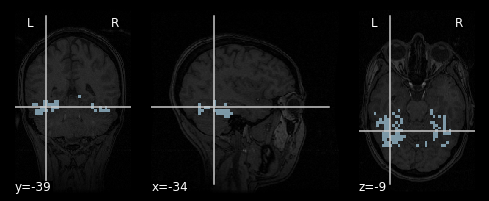

In [4]:
mask_filename = haxby_dataset.mask_vt[0]

# Let's visualize it, using the subject's anatomical image as a background
plotting.plot_roi(mask_filename, bg_img=haxby_dataset.anat[0], cmap='Paired')

Now we use the NiftiMasker.

We first create a masker, and ask it to normalize the data to improve the
decoding. The masker will extract a 2D array ready for machine learning
with nilearn:



In [5]:
from nilearn.input_data import NiftiMasker
masker = NiftiMasker(mask_img=mask_filename, standardize=True)
fmri_masked = masker.fit_transform(fmri_filename)

The variable "fmri_masked" is a numpy array:

Its shape corresponds to the number of time-points times the number of voxels in the mask

In [6]:
print(fmri_masked.shape)
print(fmri_masked)

(1452, 464)
[[ 7.6757896e-01  2.3108697e+00 -2.0519443e-01 ... -1.0261143e+00
   8.7993503e-02  2.0720518e+00]
 [ 5.5640817e-01  1.6833434e+00 -2.4644937e-01 ... -7.0238107e-01
  -3.4570047e-01  2.0341001e+00]
 [ 7.6757896e-01  1.9186659e+00  1.0802225e-03 ... -9.9374104e-01
  -2.7630943e-01  2.1479552e+00]
 ...
 [-4.2905563e-01 -1.6896105e+00 -7.4150854e-01 ... -1.5440876e+00
   1.8054217e+00 -1.6709718e-01]
 [-1.4749455e-01 -1.8072717e+00 -2.4644937e-01 ... -1.7707009e+00
   1.5452052e+00  7.8169477e-01]
 [-2.1788482e-01 -1.4542881e+00  1.0802225e-03 ... -1.6412076e+00
   1.2676411e+00  8.9554977e-01]]


***Exercise:***

Explain your neighbor what this data is.

One way to think about what just happened is to look at it visually:

![](https://nilearn.github.io/_images/masking1.jpg)


Essentially, we can think about overlaying a 3D grid on an image. Then,
our mask tells us which cubes or "voxels" (like 3D pixels) to sample from.
Since our Nifti images are 4D files, we can't overlay a single grid --
instead, we use a series of 3D grids (one for each volume in the 4D file),
so we can get a measurement for each voxel at each timepoint. These are
reflected in the shape of the matrix ! You can check this by checking the
number of non-negative voxels in our binary brain mask.

.. seealso::
	There are many other strategies in Nilearn `for masking data and for
	generating masks <computing_and_applying_mask>`
	I'd encourage you to spend some time exploring the documentation for these.
	We can also `display this time series `sphx_glr_auto_examples_03_connectivity_plot_sphere_based_connectome.py` to get an intuition of how the
	whole brain signal is changing over time.



We'll display the first three voxels by sub-selecting values from the
matrix. You can also find more information on how to slice arrays `here
<https://docs.scipy.org/doc/numpy-1.13.0/reference/arrays.indexing.html#basic-slicing-and-indexing>`_.


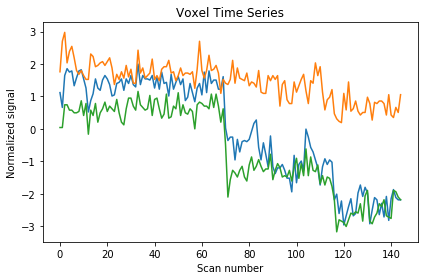

In [7]:
import matplotlib.pyplot as plt
plt.plot(fmri_masked[5:150, :3])

plt.title('Voxel Time Series')
plt.xlabel('Scan number')
plt.ylabel('Normalized signal')
plt.tight_layout()

***Exercise:***

Can you find a way to plot some of the fmri_masked-array? 

Tip (plt.imshow & the notion of slicing) will help you!

[Tip2: to insert a cell, either click insert -> cell, or press Esc and then 'b']

#### Load the behavioral labels


Now that the brain images are converted to a data matrix, we can apply 
machine-learning to them, for instance to predict the task that the subject 
was doing. The behavioral labels are stored in a CSV file, separated by
spaces.

We use pandas to load them in an array.



In [8]:
import pandas as pd
# Load behavioral information
behavioral = pd.read_csv(haxby_dataset.session_target[0], delimiter=' ')
print(behavioral)

     labels  chunks
0      rest       0
1      rest       0
2      rest       0
3      rest       0
4      rest       0
...     ...     ...
1447   rest      11
1448   rest      11
1449   rest      11
1450   rest      11
1451   rest      11

[1452 rows x 2 columns]


The task was a visual-recognition task, and the labels denote the 
experimental condition: the type of object that was presented to the 
subject. This is what we are going to try to predict.



In [9]:
conditions = behavioral['labels']
conditions

0       rest
1       rest
2       rest
3       rest
4       rest
        ... 
1447    rest
1448    rest
1449    rest
1450    rest
1451    rest
Name: labels, Length: 1452, dtype: object

Restrict the analysis to cats and faces
........................................

As we can see from the targets above, the experiment contains many
conditions. As a consequence the data is quite big:



In [10]:
print(fmri_masked.shape)

(1452, 464)


Not all of this data has an interest to us for decoding, so we will keep
only fmri signals corresponding to faces or cats. We create a mask of
the samples belonging to the condition; this mask is then applied to the
fmri data to restrict the classification to the face vs cat discrimination.
As a consequence, the input data is much small (i.e. fmri signal is shorter):



In [11]:
condition_mask = conditions.isin(['face', 'cat'])
fmri_masked = fmri_masked[condition_mask]
print(fmri_masked.shape)

(216, 464)


We apply the same mask to the targets



In [12]:
conditions = conditions[condition_mask]
print(conditions.shape)

(216,)


***Exercise:***

Again, take a moment to reflect and talk this through with your neighbor. Where are we now? What can we do next?
you can write a few notes into the comment/markdown cell below (Tip: to change a cell to a comment/markdown  cell, you either press Esc + 'm' or change the type in the pulldown-menu above.

Decoding with an SVM
---------------------

We will now use the `scikit-learn <http://www.scikit-learn.org>`_
machine-learning toolbox on the fmri_masked data.

As a decoder, we use a Support Vector Classification, with a linear
kernel.

We first create it:



In [13]:
from sklearn.svm import SVC
svc = SVC(kernel='linear')
print(svc)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)


The svc object is an object that can be fit (or trained) on data with
labels, and then predict labels on data without.

We first fit it on the data



In [14]:
svc.fit(fmri_masked, conditions)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

We can then predict the labels from the data



In [15]:
prediction = svc.predict(fmri_masked)
print(prediction)

['face' 'face' 'face' 'face' 'face' 'face' 'face' 'face' 'face' 'cat'
 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'face' 'face' 'face'
 'face' 'face' 'face' 'face' 'face' 'face' 'cat' 'cat' 'cat' 'cat' 'cat'
 'cat' 'cat' 'cat' 'cat' 'face' 'face' 'face' 'face' 'face' 'face' 'face'
 'face' 'face' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat'
 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'face' 'face' 'face'
 'face' 'face' 'face' 'face' 'face' 'face' 'face' 'face' 'face' 'face'
 'face' 'face' 'face' 'face' 'face' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat'
 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat'
 'face' 'face' 'face' 'face' 'face' 'face' 'face' 'face' 'face' 'face'
 'face' 'face' 'face' 'face' 'face' 'face' 'face' 'face' 'cat' 'cat' 'cat'
 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'face' 'face' 'face' 'face' 'face'
 'face' 'face' 'face' 'face' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat'
 'cat' 'cat' 'face' 'face' 'face' 'face' 'face' 'face' 'face' '

Let's measure the error rate:



In [16]:
print((prediction == conditions).sum() / float(len(conditions)))

1.0


***Exercise:***

This error rate is meaningless. 

Why?


Measuring prediction scores using cross-validation
---------------------------------------------------

The proper way to measure error rates or prediction accuracy is via
cross-validation: leaving out some data and testing on it.

Manually leaving out data
..........................

Let's leave out the 30 last data points during training, and test the
prediction on these 30 last points:



In [18]:
svc.fit(fmri_masked[:-30], conditions[:-30])

prediction = svc.predict(fmri_masked[-30:])
print((prediction == conditions[-30:]).sum() / float(len(conditions[-30:])))

0.6666666666666666


#### Implementing a KFold loop


We can split the data in train and test set repetitively in a `KFold`
strategy:



In [19]:
from sklearn.model_selection import KFold

cv = KFold(n_splits=5)

# The "cv" object's split method can now accept data and create a
# generator which can yield the splits.
for train, test in cv.split(X=fmri_masked):
    conditions_masked = conditions.values[train]
    svc.fit(fmri_masked[train], conditions_masked)
    prediction = svc.predict(fmri_masked[test])
    print((prediction == conditions.values[test]).sum()
           / float(len(conditions.values[test])))

0.9772727272727273
0.7674418604651163
0.7906976744186046
0.5348837209302325
0.7441860465116279


#### Cross-validation with scikit-learn
Scikit-learn has tools to perform cross-validation easier:

In [20]:
from sklearn.model_selection import cross_val_score
cv_score = cross_val_score(svc, fmri_masked, conditions)
print(cv_score)

[0.59722222 0.80555556 0.55555556]


We can speed things up to use all the CPUs of our computer with the n_jobs parameter.

The best way to do cross-validation is to respect the structure of the experiment, for instance by leaving out full sessions of acquisition.

The number of the session is stored in the CSV file giving the behavioral data. We have to apply our session mask, to select only cats and faces.

In [21]:
session_label = behavioral['chunks'][condition_mask]

# By default, cross_val_score uses a 3-fold KFold. We can control this by
# passing the "cv" object, here a 5-fold:
cv_score = cross_val_score(svc, fmri_masked, conditions, cv=cv)
print(cv_score)

[0.97727273 0.76744186 0.79069767 0.53488372 0.74418605]


The fMRI data is acquired by sessions, and the noise is autocorrelated
in a given session. Hence, it is better to predict across sessions when
doing cross-validation. To leave a session out, pass it to the groups
parameter of cross_val_score.



In [22]:
from sklearn.model_selection import LeaveOneGroupOut
cv = LeaveOneGroupOut()
cv_score = cross_val_score(svc,
                           fmri_masked,
                           conditions,
                           cv=cv,
                           groups=session_label,
                           )
print(cv_score)

[0.55555556 1.         0.66666667 0.66666667 0.77777778 0.72222222
 0.88888889 0.38888889 0.66666667 0.5        0.77777778 0.66666667]


Inspecting the model weights
-----------------------------

Finally, it may be useful to inspect and display the model weights.

Turning the weights into a nifti image

We retrieve the SVC discriminating weights



In [23]:
coef_ = svc.coef_
print(coef_)

[[-4.10657595e-02 -8.37167472e-04 -2.35012681e-02 -3.47466593e-02
   3.44083769e-02  2.59066801e-02  2.39041211e-02 -4.95035653e-02
  -3.19460172e-02 -1.65914681e-02  1.87562204e-02 -7.79177473e-03
   1.02056249e-02 -3.23105903e-02  4.77763023e-03  2.20189250e-02
   1.50937850e-02  1.77028568e-03  2.41596556e-02 -3.24642432e-02
   1.30986111e-02 -9.66189754e-02 -7.07527856e-02  1.92783989e-02
   3.57743244e-02 -1.43958701e-02 -9.17680596e-03 -3.23610899e-02
   2.34852610e-02  1.01924891e-01  1.61408709e-02 -7.79734301e-02
   2.50118393e-03 -3.13776651e-02 -2.80087685e-02 -5.16147217e-02
  -6.94852906e-03 -1.00571543e-02 -2.96089438e-02 -2.25490359e-02
  -3.00422548e-02 -3.28099135e-02  2.65749798e-02  1.66034820e-02
  -1.63207805e-02  3.33134845e-02  4.61645555e-04  7.31156716e-03
   2.85303954e-02  1.98786965e-02  2.65797203e-02  1.87621215e-02
  -2.05313506e-02 -9.08390464e-03 -4.53161747e-02  1.59157705e-02
  -1.75423001e-02 -6.90779058e-02  3.89529758e-02 -1.28827269e-01
  -3.50347

It's a numpy array with only one coefficient per voxel:



In [24]:
print(coef_.shape)

(1, 464)


We need to turn it back into a Nifti image, in essence, "inverting" what the NiftiMasker has done.

In other words, we "map" the 1-d vector (in this case the svm coefficients for each voxel in our mask) back into the brain-space from which they were taken.

For this, we can call inverse_transform on the NiftiMasker:

In [25]:
coef_img = masker.inverse_transform(coef_)
print(coef_img)

<class 'nibabel.nifti1.Nifti1Image'>
data shape (40, 64, 64, 1)
affine: 
[[  -3.5      0.       0.      68.25 ]
 [   0.       3.75     0.    -118.125]
 [   0.       0.       3.75  -118.125]
 [   0.       0.       0.       1.   ]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [ 4 40 64 64  1  1  1  1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float64
bitpix          : 64
slice_start     : 0
pixdim          : [-1.    3.5   3.75  3.75  1.    1.    1.    1.  ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_f

#### Plotting the SVM weights

coef_img is now a NiftiImage. We can save the coefficients as a nii.gz file:
And we can plot the weights, using the subject's anatomical as a background

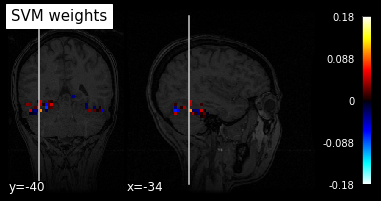

In [26]:
coef_img.to_filename('haxby_svc_weights.nii.gz')

from nilearn.plotting import plot_stat_map, show

plot_stat_map(coef_img, bg_img=haxby_dataset.anat[0],
              title="SVM weights", display_mode="yx")

show()

***Exercise:***

Inspect the weights. What do you find? 

Where in the brain are we? What do we know about this region?

How do you interpret this result?

